In [1]:
%matplotlib inline
import os
import tensorflow as tf
import tensorflow.feature_column as fc
import pandas as pd
import numpy as np
tf.__version__

'1.11.0'

We're looking at all June flights departing from ATL (Atlanta) between 2006 and 2017

In [23]:
DATA_DIR = "/home/wgiersche/workspace/data/"
ALL_ATL_JUNE = os.path.join(DATA_DIR, 'atl_june.csv')
TRAIN_FILE=os.path.join(DATA_DIR, 'atl_june_train.csv')
TEST_FILE=os.path.join(DATA_DIR, 'atl_june_test.csv')

In [47]:
NUM_RECORDS = !cat $ALL_ATL_JUNE | wc -l
NUM_RECORDS = int(NUM_RECORDS[0]) - 1
NUM_TRAIN = 80000
NUM_TEST = 1000
NUM_RECORDS

403358

In [51]:
df = pd.read_csv(ALL_ATL_JUNE)
df_sample = df.sample(frac=1.0, random_state=1) # pd.sample() also shuffles the records
df_sample[:NUM_TRAIN].to_csv(TRAIN_FILE, index=False)
df_sample[NUM_TRAIN: NUM_TRAIN + NUM_TEST].to_csv(TEST_FILE, index=False)
df_train = pd.read_csv(TRAIN_FILE)
df_test = pd.read_csv(TEST_FILE)
df_train.describe()

,FL_YEAR,FL_MONTH,FL_DOM,FL_DOW,FL_NUM,ORIGIN_AIRPORT_SEQ_ID,DEST_AIRPORT_SEQ_ID,CRS_DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,DIVERTED,DISTANCE
count,80000.000000,80000.0,80000.000000,80000.000000,80000.000000,8.000000e+04,8.000000e+04,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.0,0.0,80000.0,80000.000000
mean,2011.408238,6.0,15.570662,3.958788,2314.884613,1.039704e+06,1.278425e+06,1461.624937,15.034200,20.634438,1489.702075,1515.102238,6.061637,1552.658788,11.969088,0.0,NaN,0.0,644.620450
std,3.441472,0.0,8.632857,1.967826,1825.793593,9.996253e-01,1.520593e+05,463.718150,38.671364,11.416061,498.195315,540.071555,4.558473,501.811703,41.843313,0.0,NaN,0.0,471.980764
min,2006.000000,6.0,1.000000,1.000000,1.000000,1.039703e+06,1.013501e+06,530.000000,-54.000000,0.000000,1.000000,1.000000,0.000000,0.000000,-51.000000,0.0,NaN,0.0,79.000000
25%,2008.000000,6.0,8.000000,2.000000,864.750000,1.039703e+06,1.129802e+06,1035.000000,-3.000000,14.000000,1051.000000,1128.000000,4.000000,1148.000000,-10.000000,0.0,NaN,0.0,356.000000
50%,2011.000000,6.0,16.000000,4.000000,1704.000000,1.039703e+06,1.294502e+06,1455.000000,0.000000,18.000000,1512.000000,1537.000000,5.000000,1558.000000,-1.000000,0.0,NaN,0.0,547.000000
75%,2014.000000,6.0,23.000000,6.000000,4317.000000,1.039705e+06,1.410001e+06,1859.000000,15.000000,24.000000,1927.000000,1950.000000,7.000000,2000.000000,16.000000,0.0,NaN,0.0,743.000000
max,2017.000000,6.0,30.000000,7.000000,7425.000000,1.039705e+06,1.591902e+06,2350.000000,1207.000000,221.000000,2400.000000,2400.000000,154.000000,2359.000000,1221.000000,0.0,NaN,0.0,4502.000000


In [52]:
df_test.describe()

,FL_YEAR,FL_MONTH,FL_DOM,FL_DOW,FL_NUM,ORIGIN_AIRPORT_SEQ_ID,DEST_AIRPORT_SEQ_ID,CRS_DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,DIVERTED,DISTANCE
count,1000.000000,1000.0,1000.000000,1000.000000,1000.000000,1.000000e+03,1.000000e+03,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.0,0.0,1000.0,1000.000000
mean,2011.324000,6.0,15.821000,3.910000,2303.853000,1.039704e+06,1.276233e+06,1450.721000,14.46700,20.545000,1474.533000,1495.111000,6.047000,1548.802000,11.156000,0.0,NaN,0.0,657.659000
std,3.413308,0.0,8.683453,1.977324,1828.160539,9.966189e-01,1.493613e+05,462.847873,35.83821,11.331389,501.343349,542.315992,3.996594,497.349923,39.101184,0.0,NaN,0.0,526.401998
min,2006.000000,6.0,1.000000,1.000000,1.000000,1.039703e+06,1.013503e+06,620.000000,-47.00000,0.000000,2.000000,3.000000,0.000000,5.000000,-55.000000,0.0,NaN,0.0,83.000000
25%,2008.000000,6.0,8.000000,2.000000,871.750000,1.039703e+06,1.130801e+06,1020.750000,-3.00000,14.000000,1043.000000,1115.000000,4.000000,1140.750000,-10.000000,0.0,NaN,0.0,341.000000
50%,2011.000000,6.0,16.000000,4.000000,1673.000000,1.039703e+06,1.289201e+06,1450.000000,0.00000,18.000000,1507.500000,1522.000000,5.000000,1600.000000,-1.000000,0.0,NaN,0.0,547.000000
75%,2014.000000,6.0,23.000000,6.000000,4344.500000,1.039705e+06,1.409802e+06,1850.000000,14.00000,24.000000,1907.250000,1928.250000,7.000000,1944.000000,15.000000,0.0,NaN,0.0,745.000000
max,2017.000000,6.0,30.000000,7.000000,7348.000000,1.039705e+06,1.591902e+06,2336.000000,317.00000,126.000000,2359.000000,2400.000000,52.000000,2359.000000,307.000000,0.0,NaN,0.0,4502.000000


In [53]:
try:
    sess.close()
except:
    print("OK. Was already closed or didn't exist. That's fine.")
    
sess = tf.InteractiveSession()

---
---
#### Tensorflow input_function
An input function is a function that takes no arguments and returns a graph that produces records from a dataset or its iterator

In [54]:
COLUMNS = ['FL_DATE', 'FL_YEAR', 'FL_MONTH', 'FL_DOM', 'FL_DOW', 'UNIQUE_CARRIER', 'FL_NUM',
       'ORIGIN_AIRPORT_SEQ_ID', 'DEST_AIRPORT_SEQ_ID', 'ORIGIN', 'DEST',
       'CRS_DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON',
       'TAXI_IN', 'CRS_ARR_TIME', 'ARR_DELAY', 'CANCELLED',
       'CANCELLATION_CODE', 'DIVERTED', 'DISTANCE']
SELECT_COLUMNS=[1,4, 5,10,11,12,17,18,22]
SELECT_FEATURES = ['FL_YEAR', 'FL_DOW', 'UNIQUE_CARRIER', 'DEST', 'CRS_DEP_TIME', 'DEP_DELAY', 'CRS_ARR_TIME', 'DISTANCE']
DEFAULTS = [["-"], [], [], [], [], ["-"], ["-"], ["-"], ["-"], ["-"], ["-"], [], [], [], [], [], [], [], [], [], ['NONE'], [], []]

In [55]:
def make_decode_csv(col_names, select_indexes, defaults, label_name) :
    selected_defaults = [defaults[i] for i in select_indexes]
    def _decode_csv(row): 
        cols = tf.decode_csv(row, select_cols=select_indexes, 
                             record_defaults=selected_defaults)
        decoded = dict(zip([col_names[i] for i in select_indexes], cols))
        label = decoded.pop(label_name)
        return decoded, label
    return _decode_csv

        
def make_input_fn(file_name, headers, col_names, label_name, indexes, defaults, transform=None, batch_size=1, repeat=1):
    
    decode_csv = make_decode_csv(col_names, indexes, defaults, label_name)
    
    def _input_fn():
        text_lines = tf.data.TextLineDataset(file_name)
        if headers:
            text_lines=text_lines.skip(1)
        decoded = text_lines.map(decode_csv)

        if transform is not None:
            decoded = decoded.map(transform)
        
        features = decoded.repeat(repeat).batch(batch_size).make_one_shot_iterator().get_next()
        return features
    
    return _input_fn

---
---
See how lines of csv are parsed into tensors

In [9]:
defaults = [tf.constant([0]), tf.constant([0]), tf.constant(['CHF'])]
decode_csv = make_decode_csv(['a', 'b', 'c'], [0,1,2], defaults, 'c')
row = tf.constant(["10,20,Dollar", "20,30,SGD"])

In [10]:
feats, labels = decode_csv(row)
feats['a'].eval(), labels.eval()

(array([10, 20], dtype=int32), array(['Dollar', 'SGD'], dtype=object))

---
---
Any additional transformation like e.g. one-hot encoding or bucketizing is done in this transform function

In [11]:
def transform(feats, labels):
    
    dow = feats['FL_DOW']
    dow = tf.cast(dow, tf.int64)
    dow_hot = tf.one_hot(dow-1, 7, dtype=tf.int64)
    feats['FL_DOW'] = dow_hot

    dep_time = feats['CRS_DEP_TIME'] / 100.0
    dep_time = tf.cast(dep_time, tf.int64)
    dt_hot = tf.one_hot(dep_time, 24, dtype=tf.int64)
    feats['CRS_DEP_TIME'] = dt_hot
    
    arr_time = feats['CRS_ARR_TIME'] / 100.0
    arr_time = tf.cast(arr_time, tf.int64)
    at_hot = tf.one_hot(arr_time, 24, dtype=tf.int64)
    feats['CRS_ARR_TIME'] = at_hot

    dist = feats['DISTANCE'] / 1000.0
    feats['DISTANCE'] = dist
    
    dep_d = feats['DEP_DELAY']
    feats['DEP_DELAY'] = dep_d
    
    return feats, labels

---
---
The input function returns a pair consisting of a dictionary of input tensors and a label tensor.
These tensors are actually datasets, that produce the respective next batch, when evaluated. That's how we avoid loading the entire dataset into memory for training.

In [12]:
input_fn = make_input_fn(TRAIN_FILE,
    True, COLUMNS, 'ARR_DELAY', SELECT_COLUMNS, DEFAULTS, transform, 2)

In [13]:
input_fn()

({'CRS_ARR_TIME': <tf.Tensor 'IteratorGetNext:0' shape=(?, 24) dtype=int64>,
  'CRS_DEP_TIME': <tf.Tensor 'IteratorGetNext:1' shape=(?, 24) dtype=int64>,
  'DEP_DELAY': <tf.Tensor 'IteratorGetNext:2' shape=(?,) dtype=float32>,
  'DEST': <tf.Tensor 'IteratorGetNext:3' shape=(?,) dtype=string>,
  'DISTANCE': <tf.Tensor 'IteratorGetNext:4' shape=(?,) dtype=float32>,
  'FL_DOW': <tf.Tensor 'IteratorGetNext:5' shape=(?, 7) dtype=int64>,
  'FL_YEAR': <tf.Tensor 'IteratorGetNext:6' shape=(?,) dtype=float32>,
  'UNIQUE_CARRIER': <tf.Tensor 'IteratorGetNext:7' shape=(?,) dtype=string>},
 <tf.Tensor 'IteratorGetNext:8' shape=(?,) dtype=float32>)

In [14]:
feats, delay = input_fn()
all_tensors = [feats[name] for name in SELECT_FEATURES]
all_tensors.append(delay)
with tf.Session() as sess:
    for _ in range(2):
        print(sess.run(all_tensors))

[array([2006., 2011.], dtype=float32), array([[1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0]]), array(['FL', 'EV'], dtype=object), array(['MCO', 'MGM'], dtype=object), array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0]]), array([-3., 20.], dtype=float32), array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0]]), array([4.0299997, 1.4699999], dtype=float32), array([-9., 25.], dtype=float32)]
[array([2008., 2007.], dtype=float32), array([[0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0, 0]]), array(['DL', 'EV'], dtype=object), array(['PNS', 'GSO'], dtype=object), array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0]]), 

Let's compare that to what the equivalent pandas dataframe shows

In [15]:
df_train[0:4][['FL_YEAR', 'FL_DOW', 'UNIQUE_CARRIER', 'DEST', 'CRS_DEP_TIME', 'DEP_DELAY', 'CRS_ARR_TIME', 'ARR_DELAY', 'DISTANCE']]

,FL_YEAR,FL_DOW,UNIQUE_CARRIER,DEST,CRS_DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_DELAY,DISTANCE
0,2006,1,FL,MCO,1024,-3,1148,-9,403
1,2011,5,EV,MGM,1915,20,1910,25,147
2,2008,6,DL,PNS,1718,-1,1735,4,272
3,2007,4,EV,GSO,1725,7,1846,5,306


Cool! That seems to work! The input function produces the same values that we can see in the training data.

---
---
First, we'll only be looking at departure delay and distance to destination to predict arrival delay

In [12]:
fc_dep_delay = fc.numeric_column('DEP_DELAY', dtype=tf.float32)
fc_distance = fc.numeric_column('DISTANCE', dtype=tf.float32)

In [13]:
regressor = tf.estimator.LinearRegressor(feature_columns=[fc_dep_delay, fc_distance])

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_global_id_in_cluster': 0, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc264d97550>, '_model_dir': '/tmp/tmpqHZpO9', '_protocol': None, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_device_fn': None, '_experimental_distribute': None, '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_evaluation_master': '', '_eval_distribute': None, '_train_distribute': None, '_master': ''}


In [14]:
pred_input_fn = make_input_fn(TEST_FILE,
    True, COLUMNS, 'ARR_DELAY', SELECT_COLUMNS, DEFAULTS, transform, NUM_TEST, 1)

In [15]:
NUM_EPOCHS = 20
BATCH_SIZE = 400

In [16]:
train_input_fn = make_input_fn(TRAIN_FILE,
    True, COLUMNS, 'ARR_DELAY', SELECT_COLUMNS, DEFAULTS, transform, BATCH_SIZE, NUM_EPOCHS)

In [17]:
regressor.train(train_input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpqHZpO9/model.ckpt.
INFO:tensorflow:loss = 688373.0, step = 1
INFO:tensorflow:global_step/sec: 37.9712
INFO:tensorflow:loss = 113418.83, step = 101 (2.635 sec)
INFO:tensorflow:global_step/sec: 37.5683
INFO:tensorflow:loss = 113119.91, step = 201 (2.662 sec)
INFO:tensorflow:global_step/sec: 40.4147
INFO:tensorflow:loss = 113125.77, step = 301 (2.475 sec)
INFO:tensorflow:global_step/sec: 37.8246
INFO:tensorflow:loss = 113123.88, step = 401 (2.643 sec)
INFO:tensorflow:global_step/sec: 35.6324
INFO:tensorflow:loss = 113110.65, step = 501 (2.807 sec)
INFO:tensorflow:global_step/sec: 33.1474
INFO:tensorflow:loss = 113094.336, step = 601 (3.017 sec)
INFO:tensorflow:global_step/sec: 40.2091
INFO:tensorflow:lo

---
---
Let's see whether our forecast is any good

In [18]:
def test_prediction(pred, test_file, num_test):
    """
    pred: the result of regressor.predict()
    test_file
    """
    dataframe=pd.read_csv(test_file)
    predicted = [pred.next()['predictions'][0] for i in range (num_test)]
    np_pred = np.array(predicted)
    lbls = list(dataframe[0:num_test]['ARR_DELAY'])
    np_lbls = np.array(lbls)
    avg_err = np.average(np.abs(np_lbls - np_pred))
    rmse = np.sqrt(np.average(np.square(np_lbls - np_pred)))
    pd.DataFrame(np_lbls - np_pred).plot.hist(bins=40)
    print
    print("Average error: {}, RMSE: {}". format(avg_err, rmse))

In [19]:
pred_input_fn = make_input_fn(
    TEST_FILE, True, COLUMNS, 'ARR_DELAY', 
    SELECT_COLUMNS, DEFAULTS, transform, NUM_TEST, 1)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpqHZpO9/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.

Average error: 9.4458076742, RMSE: 14.2334594022


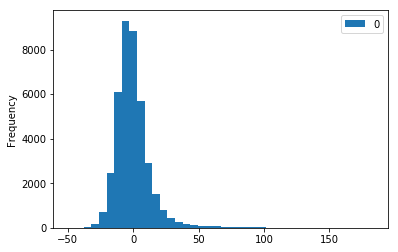

In [20]:
res = regressor.predict(pred_input_fn)
test_prediction(res, TEST_FILE, NUM_TEST)

### Taking more features into account
We see that predictions are not too shabby, however we may get better by taking day of week and time of departure and arrival into account...

In [25]:
fc_crs_dep_time = fc.categorical_column_with_identity('CRS_DEP_TIME', 24)
fc_crs_arr_time = fc.categorical_column_with_identity('CRS_ARR_TIME', 24)
fc_dow = fc.categorical_column_with_identity('FL_DOW', 7)

feature_columns=[
    fc_dep_delay, 
    fc_distance, 
    fc_crs_dep_time, 
    fc_crs_arr_time,
    fc_dow]

regressor2 = tf.estimator.LinearRegressor(feature_columns=feature_columns)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_global_id_in_cluster': 0, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fee71a2e910>, '_model_dir': '/tmp/tmpvETGro', '_protocol': None, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_device_fn': None, '_experimental_distribute': None, '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_evaluation_master': '', '_eval_distribute': None, '_train_distribute': None, '_master': ''}


In [26]:
regressor2.train(train_input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpvETGro/model.ckpt.
INFO:tensorflow:loss = 805067.0, step = 1
INFO:tensorflow:global_step/sec: 30.7323
INFO:tensorflow:loss = 744304.4, step = 101 (3.255 sec)
INFO:tensorflow:global_step/sec: 34.0309
INFO:tensorflow:loss = 742268.0, step = 201 (2.939 sec)
INFO:tensorflow:global_step/sec: 32.9714
INFO:tensorflow:loss = 740724.5, step = 301 (3.033 sec)
INFO:tensorflow:global_step/sec: 32.1446
INFO:tensorflow:loss = 739427.4, step = 401 (3.111 sec)
INFO:tensorflow:global_step/sec: 35.863
INFO:tensorflow:loss = 738286.0, step = 501 (2.788 sec)
INFO:tensorflow:global_step/sec: 32.8507
INFO:tensorflow:loss = 737254.4, step = 601 (3.044 sec)
INFO:tensorflow:global_step/sec: 31.0166
INFO:tensorflow:loss = 736

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpvETGro/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.

Average error: 25.3021452069, RMSE: 41.3581963153


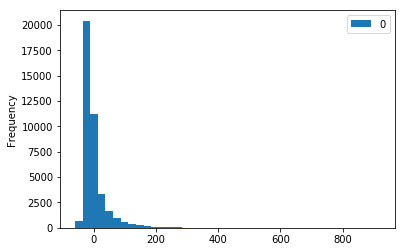

In [27]:
res = regressor2.predict(pred_input_fn)
test_prediction(res, TEST_FILE, NUM_TEST)